This notebook tests whether the APE signal resumes where is left off the day before (or lower)

In [1]:
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from set_global_params import processed_data_path, change_over_time_mice
from utils.stats import cohen_d_one_sample

In [2]:
# load all APE contra values
# requires supp6/movement_vs_trial_num_regression/get_regression_slopes_for_turn_angle_speed_trial_number_vs_APE.py
# currently need python 3.6 to read pickles 
mice = change_over_time_mice['tail']
for i, mouse in enumerate(mice):
    df_save_dir = r'{}{}\turn_angle_over_time'.format(processed_data_path,mouse)
    df_save_file = os.path.join(df_save_dir, 'movement_params_all_trials_vs_APE_{}.pkl'.format(mouse))
    valid_contra_data = pd.read_pickle(df_save_file)
    sorted_data = valid_contra_data.sort_values(by='actual trial numbers').reset_index(drop=True)
    sessions = sorted_data.date.unique()
    for ii, session in enumerate(sessions):
        session_data = sorted_data[sorted_data.date == session]
        first_trials = session_data.iloc[0:40]['APE peaks'].mean()
        last_trials = session_data.iloc[-41:-1]['APE peaks'].mean()
        if ii == 0:
            beginning_and_end_all_sessions = pd.DataFrame({'mouse': [mouse], 'date': [session], 'recording number': [ii], 'first trial': [first_trials],
                                                          'last trial': [last_trials]})
        else:
            beginning_and_end = pd.DataFrame({'mouse': [mouse], 'date': [session], 'recording number': [ii], 'first trial': [first_trials],
                                                          'last trial': [last_trials]})
            beginning_and_end_all_sessions = pd.concat([beginning_and_end_all_sessions, beginning_and_end])
    beginning_and_end_all_sessions['end of last session'] = beginning_and_end_all_sessions['last trial'].shift(1)
    beginning_and_end_all_sessions['within \n session'] = beginning_and_end_all_sessions['last trial'] - beginning_and_end_all_sessions['first trial'] 
    beginning_and_end_all_sessions['between \n sessions'] = beginning_and_end_all_sessions['first trial'] - beginning_and_end_all_sessions['end of last session'] 
    
    df_for_test = beginning_and_end_all_sessions
    #print(ttest_rel(df_for_test['first trial'], df_for_test['end of last session']))
    if i == 0: 
        df_for_test_all_mice =  df_for_test
    else: 
        df_for_test_all_mice = pd.concat([df_for_test_all_mice, df_for_test])

In [3]:
df_for_test_all_mice

,mouse,date,recording number,first trial,last trial,end of last session,within \n session,between \n sessions
0,SNL_photo16,20200210,0,1.569191,1.736021,NaN,0.166830,NaN
0,SNL_photo16,20200213,1,0.936847,0.933736,1.736021,-0.003111,-0.799174
0,SNL_photo16,20200218,2,1.527008,1.035059,0.933736,-0.491950,0.593272
0,SNL_photo16,20200220,3,1.157596,1.243016,1.035059,0.085419,0.122538
0,SNL_photo16,20200224,4,1.193245,0.817172,1.243016,-0.376073,-0.049771
...,...,...,...,...,...,...,...,...
0,SNL_photo26,20200822,7,1.176063,1.034841,0.777643,-0.141222,0.398420
0,SNL_photo26,20200824,8,1.740940,1.030621,1.034841,-0.710319,0.706099
0,SNL_photo26,20200826,9,1.889746,1.317329,1.030621,-0.572416,0.859125
0,SNL_photo26,20200827,10,1.548226,1.405896,1.317329,-0.142330,0.230897


In [4]:
per_mouse_df = df_for_test_all_mice.groupby(['mouse'])['between \n sessions', 'within \n session'].apply(np.mean)

C:\Users\francescag\AppData\Local\Continuum\miniconda3\envs\dlc_analysis\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [5]:
per_mouse_df.index

Index(['SNL_photo16', 'SNL_photo17', 'SNL_photo18', 'SNL_photo21',
       'SNL_photo22', 'SNL_photo26'],
      dtype='object', name='mouse')

In [28]:
ttest_1samp(per_mouse_df['between \n sessions'], 0)

Ttest_1sampResult(statistic=1.254540704349115, pvalue=0.26509545812982227)

In [6]:
cohen_d_one_sample(per_mouse_df['between \n sessions'])

cohen d:  0.5121640978678568


0.5121640978678568

In [29]:
ttest_1samp(per_mouse_df['within \n session'], 0)

Ttest_1sampResult(statistic=-2.626135766496434, pvalue=0.046750513191381626)

In [7]:
cohen_d_one_sample(per_mouse_df['within \n session'])

cohen d:  -1.0721154371981758


-1.0721154371981758

In [57]:
melted_df = pd.melt(per_mouse_df.reset_index(), id_vars=['mouse'], value_vars=['between \n sessions', 'within \n session'], value_name='change in z-scored dopamine response', var_name='difference')

In [60]:
melted_df.columns

Index(['mouse', 'difference', 'change in z-scored dopamine response'], dtype='object')

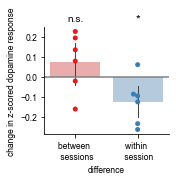

In [62]:
font = {'size': 8.5, 'family':'sans-serif', 'sans-serif':['Arial']}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1,1, figsize=[2.5,2.5])
matplotlib.rcParams['pdf.fonttype'] = 42


sns.barplot(data=melted_df, x='difference', y='change in z-scored dopamine response', ax=ax, palette='Set1', errwidth=1, alpha=0.4)
sns.swarmplot(data=melted_df,x='difference', y='change in z-scored dopamine response', ax=ax, palette='Set1')


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
y = melted_df['change in z-scored dopamine response'].to_numpy().max() + 0.05
h = .1
ax.text(0, y, 'n.s.', ha='center', fontsize=10)
ax.text(1, y, '*', ha='center', fontsize=12)
ax.axhline(0, color='gray')
plt.tight_layout()